In [2]:
from numba import njit
import random

def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [9]:
%time monte_carlo_pi(1000000)

CPU times: total: 375 ms
Wall time: 439 ms


3.143032

There are several version to run jit function

In [5]:
%time njit(monte_carlo_pi)(1000000)

CPU times: total: 109 ms
Wall time: 140 ms


3.142512

In [7]:
%time njit()(monte_carlo_pi)(1000000)

CPU times: total: 93.8 ms
Wall time: 122 ms


3.140652

In [10]:
jitted_func = njit()(monte_carlo_pi)
%time jitted_func(1000000)

CPU times: total: 109 ms
Wall time: 122 ms


3.138968

## vectorize function

In [11]:
from numba import jit, njit, vectorize 
import numpy as np
def original_function(input_list):
    output_list = []
    for item in input_list:
        if item % 2 == 0:
            output_list.append(2)
        else:
            output_list.append(1)
    return output_list 

test_array = np.arange(100000)


In [14]:
%time _= original_function(test_array)

CPU times: total: 15.6 ms
Wall time: 18.9 ms


In [18]:
jitted_func = njit()(original_function)

In [20]:
%time _=jitted_func(test_array)

CPU times: total: 0 ns
Wall time: 1 ms


### Instead of having the function operating on the list, we can rewrite the function acting on a single element of that list
The vectorize decorater create a function that can accept both a normal number and iterable. 

In [22]:
@vectorize
def scalar_computation(num):
    if num % 2 == 0:
        return 0
    else:
        return 1

In [25]:

%time _=scalar_computation(test_array)

CPU times: total: 0 ns
Wall time: 0 ns


This is because we define an empty list and then appending to it. So there is no way for numba to pre allocate which spend a lot of time. So if we pre allocate the memory, the original function should takes same amount of time that the vectorized function did

In [26]:
@njit 
def fixed_function(input_list):
    output_list = np.zeros_like(input_list)
    for ii, item in enumerate(input_list):
        if item%2 == 0:
            output_list[ii] = 2
        else:
            output_list[ii] = 1
    return output_list

In [28]:
%time fixed_function(test_array)

CPU times: total: 0 ns
Wall time: 1 ms


array([2, 1, 2, ..., 1, 2, 1])

In [31]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


d:\Anaconda\envs\AI4Sci\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'vectorize']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [29]:
# Let's mix wet friction with dry friction, this makes the behavior
# of the system dependent on the initial condition, something
# may be interesting to study by running an exhaustive simluation

def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

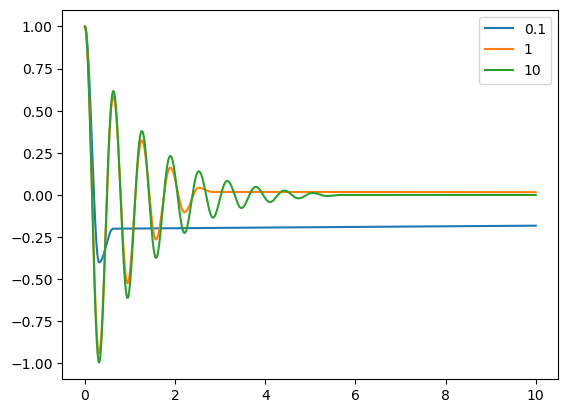

In [32]:
plot(*simulate_spring_mass_funky_damper(0.1))
plot(*simulate_spring_mass_funky_damper(1))
plot(*simulate_spring_mass_funky_damper(10))
legend(['0.1', '1', '10'])

In [33]:
%time _= simulate_spring_mass_funky_damper(0.1)

CPU times: total: 93.8 ms
Wall time: 165 ms


Now let implement @njit to the function

In [37]:
@njit
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

@njit
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions
_ = simulate_spring_mass_funky_damper(0.1)

In [35]:
%time _=simulate_spring_mass_funky_damper(0.1)

CPU times: total: 0 ns
Wall time: 2 ms


200x faster

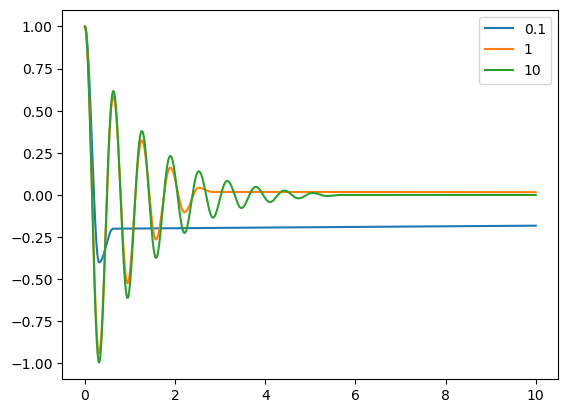

In [36]:
plot(*simulate_spring_mass_funky_damper(0.1))
plot(*simulate_spring_mass_funky_damper(1))
plot(*simulate_spring_mass_funky_damper(10))
legend(['0.1', '1', '10'])

In [47]:
%%time
test_array = np.arange(0.1,1000,0.1)
for test in test_array:
    _=simulate_spring_mass_funky_damper(test)

CPU times: total: 6.92 s
Wall time: 7.05 s


In [44]:
%%time
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(8) as ex:
    ex.map(simulate_spring_mass_funky_damper,test_array)

CPU times: total: 2.55 s
Wall time: 11.6 s


Release the global interpreter lock

In [48]:
@njit(nogil=True)
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

@njit(nogil=True)
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

# compile
_ = simulate_spring_mass_funky_damper(0.1)

In [49]:
%%time
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(8) as ex:
    ex.map(simulate_spring_mass_funky_damper,test_array)

CPU times: total: 531 ms
Wall time: 1.69 s


numba has an equivalent way for parallel your code

In [51]:
from numba import prange 

@njit(parallel=True)
def run_sims(end=1000):
    for x0 in prange(int(end/0.1)):
        if x0 ==0:
            continue
        simulate_spring_mass_funky_damper(x0*0.1)
run_sims()

In [52]:
%time run_sims()

CPU times: total: 11.3 s
Wall time: 1.35 s
